# Exercise 3: Data set, augmentation, and baseline
In this exercise we are going to explore how augmented data can be used in training and testing.

The code used in the exercise is based on the code already shown during the lecture. In this notebook you get the main code blocks to do the exercise. It helps to look at the code to get inspiration to solve the exercise. 

In [1]:
import numpy as np
import pandas as dp
import skimage.io as io
import matplotlib.pyplot as plt


## Load data
In this execercise we will be working with a CT data set from lungs which are acompanied by a list of labels to tell if the image is healthy or malign. The image slices are stored in a (3D) numpy array and the labels in a pandas data frame. [Pandas](https://pandas.pydata.org/docs/) is a libray that helps you to store tables of data that are searchable and slicable depending on different criteria.

__Note:__ Please uncompress the file ```ct_tiles.tif.zip``` before starting.

In [2]:
img = io.imread('ct_tiles.tif')
labels = dp.read_csv('malignancy.csv')
print('Image size: {0},{1},{2}'.format(img.shape[0],img.shape[1],img.shape[2]))
print('Labels {0}'.format(labels.malignancy.count() ))

Image size: 6691,64,64
Labels 6691


In [3]:
print(img.shape)

(6691, 64, 64)


### Look at the first five labels

In [4]:
labels.head()

,idx,malignancy
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


### Look at the first five slices

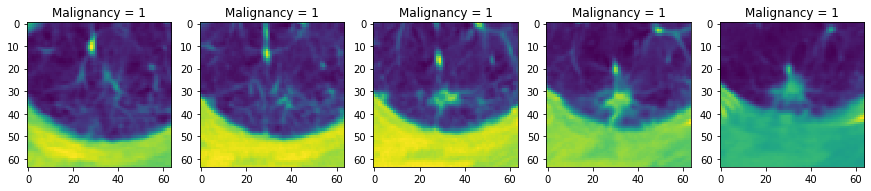

In [5]:
plt.figure(figsize=[15,5])
for idx,tile in enumerate(img[0:5]) :
    plt.subplot(1,5,idx+1)
    plt.imshow(tile) ;
    plt.title('Malignancy = {0}'.format(labels.malignancy[idx]))

### Look at the two cases
In our exercise we will work with images of healthy (imgA) and malign sample (imgB). 

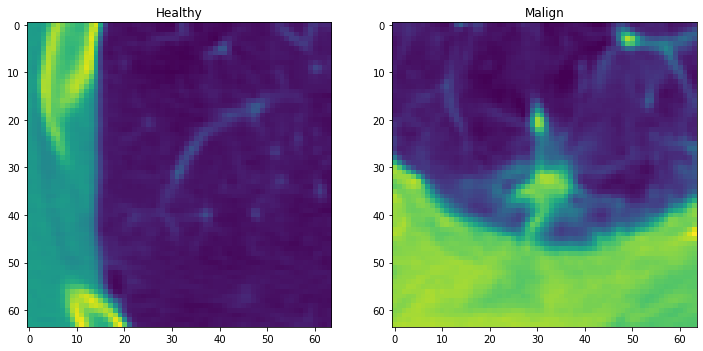

In [6]:
imgA=img[labels[labels.malignancy==0.0].idx.iloc[3]]
imgB=img[labels[labels.malignancy==1.0].idx.iloc[3]]
plt.figure(figsize=[12,7])
plt.subplot(1,2,1)
plt.imshow(imgA)
plt.title('Healthy')

plt.subplot(1,2,2)
plt.imshow(imgB)
plt.title('Malign');

## Augmenting the data
Let's create a data augmentator. Here, the values from the lecture are used, but you can play with different settings for parameters like:
- rotation
- translation
- scaling
- etc.

In [241]:
from keras.preprocessing.image import ImageDataGenerator
img_aug = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=120.0,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    fill_mode='nearest',
    horizontal_flip=False,
    vertical_flip=False
)

This is an example using the lecture code with the lung data.

(15, 64, 64, 1)
0       1
450     1
900     1
1350    1
1800    1
2250    1
2700    0
3150    0
3600    0
4050    0
4500    0
4950    0
5400    0
5850    0
6300    0
Name: malignancy, dtype: int64


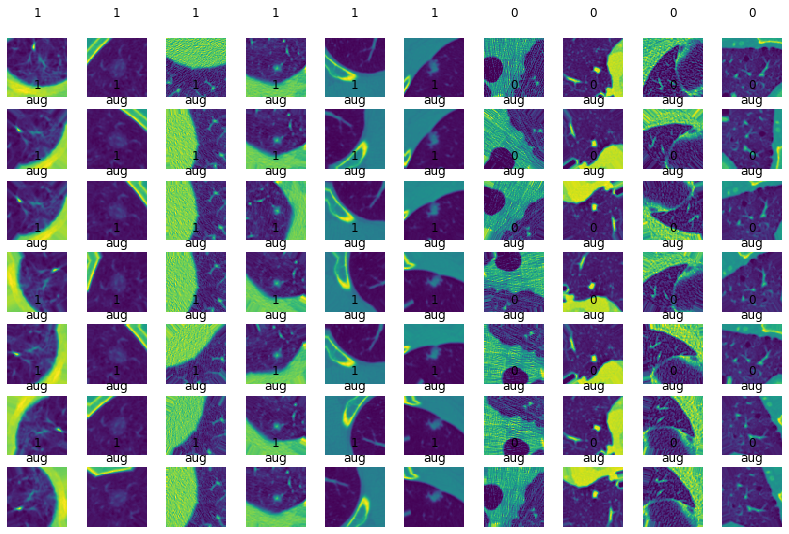

In [242]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
%matplotlib inline

# take 15 images at large intervals from each other and add dimension
tiles = np.expand_dims(img[0:6500:450], -1)
print(tiles.shape)

# get labels for the 15 slices which have taken
tileLabels = labels.malignancy[0:6500:450]
print(tileLabels)

fig, m_axs = plt.subplots(7, 10, figsize=(14, 9))

# setup augmentation
img_aug.fit(tiles)
real_aug = img_aug.flow(tiles[:10], tileLabels[:10], shuffle=False)

print(real_aug)
for c_axs, do_augmentation in zip(m_axs, [False, True, True, True, True, True, True]): # first row is original data, then augmented
    if do_augmentation:
        img_batch, label_batch = next(real_aug)
    else:
        img_batch, label_batch = tiles, tileLabels
    for c_ax, c_img, c_label in zip(c_axs, img_batch, label_batch):
        c_ax.imshow(c_img[:, :, 0], cmap='viridis')
        c_ax.set_title('{}\n{}'.format(
            c_label, 'aug' if do_augmentation else ''))
        c_ax.axis('off')

## Testing baselines with augmented data
From the lectures you learned that in order to compare the performance of an algorithm, you need a baseline algorithm. Previously, you heard about two algorithms:
- Dummy classifier which uses the majority as prediction for any input data.
- Nearest neighbor that uses the nearest feature as prediction.

Below you get examples on the lung data.

### Dummy classifier

In [9]:
from sklearn.dummy import DummyClassifier
dc = DummyClassifier(strategy='most_frequent')
dc.fit(tiles, tileLabels)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [10]:
dc.predict(img[1:6000:1000]) # just predicts the most common type -> so healthy (0)

array([0, 0, 0, 0, 0, 0])

### Nearest neighbor

In [11]:
from sklearn.neighbors import KNeighborsClassifier
neigh_class = KNeighborsClassifier(n_neighbors=1)
neigh_class.fit(tiles.reshape((15, -1)), tileLabels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [12]:
# predict on a few images
neigh_class.predict(tiles.reshape((15, -1))) # have to flatten -> take whole image as feature vector

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Confusion matrix

In [13]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Stolen from: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return ax1

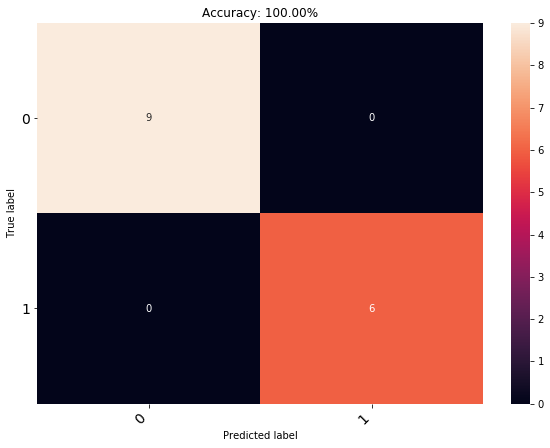

In [39]:
pred_values = neigh_class.predict(tiles.reshape((15, -1)))
ax1 = print_confusion_matrix(confusion_matrix(tileLabels, pred_values), class_names=range(2))
ax1.set_title('Accuracy: {:2.2%}'.format(accuracy_score(tileLabels, pred_values)));

As expected, we get an accuracy of 100% since we train and predict on the same data.

In [15]:
tiles.shape

(15, 64, 64, 1)

## Exercise
1. Create an augmented data set with 110 images based on 11 images. Pay attention to obtaining a representative balance between healthy and malign samples.
2. Train the baseline algorithms using 
    1. the original data of the same size as the augmented data set.
    2. the augmented data.
3. Compare the performance using the confusion matrix based on a separate testing set.

Read in all the data we need.

In [94]:
img = io.imread('ct_tiles.tif')
labels = dp.read_csv('malignancy.csv')
print('Image size: {0},{1},{2}'.format(img.shape[0],img.shape[1],img.shape[2]))
print('Labels {0}'.format(labels.malignancy.count() ))

Image size: 6691,64,64
Labels 6691


We have to split our data into a training and a testing set. We take 11 images as training data and 11 as testing data. Feel free to use more data to see how it affects performance.

In [245]:
image_number = 11

# Take "image_number" of images for training
train_x = np.expand_dims(img[0:6500:int(np.ceil(6500/image_number))], -1)
print(train_x.shape)

# get labels for the training data
train_y = labels.malignancy[0:6500:int(np.ceil(6500/image_number))]
print(train_y.shape)

# Take all odd images as training data 
test_x = np.expand_dims(img[1:6500:int(np.ceil(6500/image_number))], -1)
print(test_x.shape)

# get labels for the even images
test_y = labels.malignancy[1:6500:int(np.ceil(6500/image_number))]
print(test_y.shape)

(11, 64, 64, 1)
(11,)
(11, 64, 64, 1)
(11,)


# Case 1: train only with true data

Train the KNN:

In [246]:
from sklearn.neighbors import KNeighborsClassifier
neigh_class = KNeighborsClassifier(n_neighbors=1)
neigh_class.fit(train_x.reshape((train_x.shape[0], -1)), train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

Test the trained KNN:

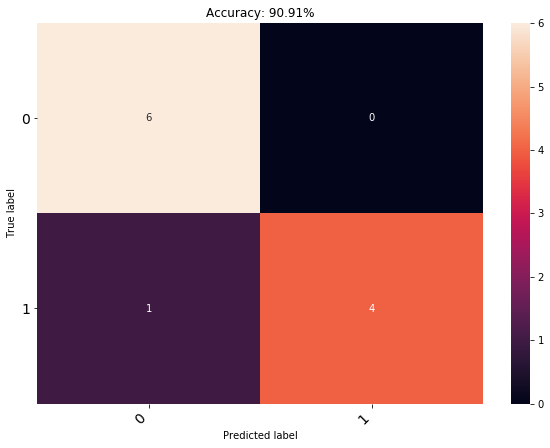

In [247]:
pred_values = neigh_class.predict(test_x.reshape((test_x.shape[0], -1)))
ax1 = print_confusion_matrix(confusion_matrix(test_y, pred_values), class_names=range(2))
ax1.set_title('Accuracy: {:2.2%}'.format(accuracy_score(test_y, pred_values)));

We observe that the testing accuracy is fairly high: 90%. Let's see if we can improve the performane with augmented data...

# Case 2: train with true and augmented data

Augment the data:

In [249]:
from keras.preprocessing.image import ImageDataGenerator
img_aug = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=120.0,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    fill_mode='nearest',
    horizontal_flip=False,
    vertical_flip=False
)

In [250]:
img_aug.fit(train_x)
real_aug = img_aug.flow(train_x, train_y, shuffle=False)

# 10 augmentations for each of the 11 images will give 110 augmented images
aug_num = 10

augmentations = []
augmented_labels = []

for i in range(aug_num): # first row is original data, then augmented
    img_batch, label_batch = next(real_aug)
    augmentations.append(img_batch) # save augmentations as elements of a list
    augmented_labels.append(label_batch) # save labels of augmented data as elements of a second list

In [251]:
train_x.shape

(11, 64, 64, 1)

In [252]:
# reshape data
augmented_train_x = np.stack(augmentations)
augmented_train_x = np.reshape(augmented_train_x, (aug_num*image_number, 64, 64, 1))
augmented_train_x.shape

(110, 64, 64, 1)

In [253]:
augmented_train_y = np.stack(augmented_labels).flatten()
augmented_train_y.shape

(110,)

Train the KNN on 110 augmented images instead of the 11 images used above.

In [254]:
from sklearn.neighbors import KNeighborsClassifier
neigh_class = KNeighborsClassifier(n_neighbors=1)
neigh_class.fit(augmented_train_x.reshape((augmented_train_x.shape[0], -1)), augmented_train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

Test the trained KNN (on the same test set as above):

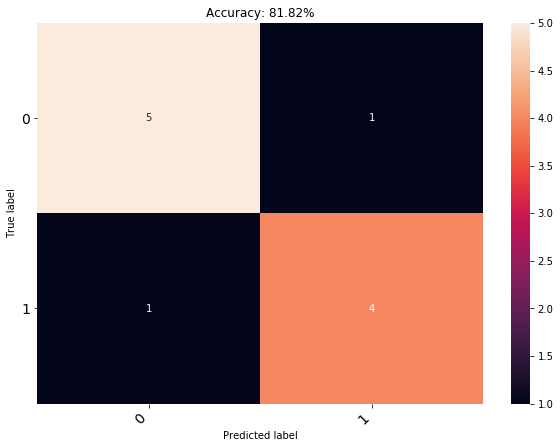

In [255]:
pred_values = neigh_class.predict(test_x.reshape((test_x.shape[0], -1)))
ax1 = print_confusion_matrix(confusion_matrix(test_y, pred_values), class_names=range(2))
ax1.set_title('Accuracy: {:2.2%}'.format(accuracy_score(test_y, pred_values)));